# Frame Unwrapping

## Context

At time-of-flight neutron sources recording event-mode, time-stamps of detected neutrons are written to files in an `NXevent_data` group.
This contains two main time components, `event_time_zero` and `event_time_offset`.
The sum of the two would typically yield the absolute detection time of the neutron.
For computation of wavelengths or energies during data-reduction, a time-of-flight is required.
In principle the time-of-flight could be equivalent to `event_time_offset`, and the emission time of the neutron to `event_time_zero`.
Since an actual computation of time-of-flight would require knowledge about chopper settings, detector positions, and whether the scattering of the sample is elastic or inelastic, this may however not be the case in practice.
Instead, the data acquisition system may, e.g., record the time at which the proton pulse hits the target as `event_time_zero`, with `event_time_offset` representing the offset since then.

We refer to the process of "unwrapping" these time stamps into an actual time-of-flight as *frame unwrapping*, since `event_time_offset` "wraps around" with the period of the proton pulse and neutrons created by different proton pulses may be recorded with the *same* `event_time_zero`.
The figures in the remainder of this document will clarify this.

In [1]:
import plopp as pp
import scipp as sc
from scippneutron.chopper import DiskChopper
from ess.reduce.nexus.types import AnyRun, RawDetector, SampleRun, NeXusDetectorName
from ess.reduce.time_of_flight import *
import tof

Hz = sc.Unit("Hz")
deg = sc.Unit("deg")
meter = sc.Unit("m")

## Default mode

Often there is a 1:1 correspondence between source pulses and neutron pulses propagated to the sample and detectors.

In this first example:

- We begin by creating a source of neutrons which mimics the ESS source.
- We set up a single chopper with a single opening
- We place 4 'monitors' along the path of the neutrons (none of which absorb any neutrons)

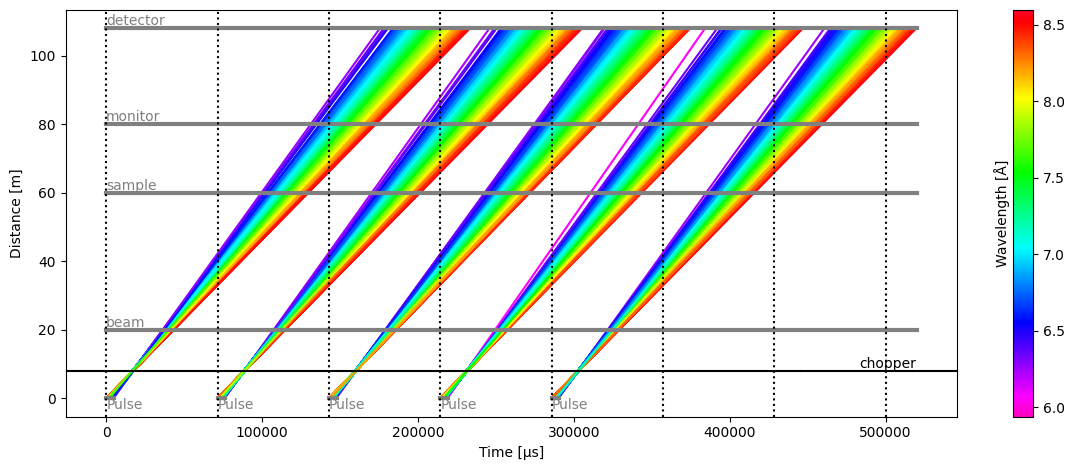

In [2]:
source = tof.Source(facility="ess", pulses=5)
chopper = tof.Chopper(
    frequency=14.0 * Hz,
    open=sc.array(dims=["cutout"], values=[0.0], unit="deg"),
    close=sc.array(dims=["cutout"], values=[3.0], unit="deg"),
    phase=85.0 * deg,
    distance=8.0 * meter,
    name="chopper",
)
detectors = [
    tof.Detector(distance=20.0 * meter, name="beam"),
    tof.Detector(distance=60.0 * meter, name="sample"),
    tof.Detector(distance=80.0 * meter, name="monitor"),
    tof.Detector(distance=108.0 * meter, name="detector"),
]

model = tof.Model(source=source, choppers=[chopper], detectors=detectors)
results = model.run()
pl = results.plot()

for i in range(2 * source.pulses):
    pl.ax.axvline(
        i * (1.0 / source.frequency).to(unit="us").value, color="k", ls="dotted"
    )

In the figure above, the dotted vertical lines represent the `event_time_zero` of each pulse,
i.e. the start of a new origin for `event_time_offset` recorded at the various detectors.

The span between two dotted lines is called a 'frame'.

The figure gives a good representation of the situation at each detector:

- **beam** monitor: all the arrival times at the detector are inside the same frame within which the neutrons were created.
- **sample**: all the arrival times are offset by one frame
- **monitor**: most of the neutrons arrive with an offset of two frames, but a small amount of neutrons (shortest wavelengths) only have a 1-frame offset
- **detector**: most of the neutrons arrive with an offset of two frames, but a small amount of neutrons (longest wavelengths) have a 3-frame offset

We can further illustrate this by making histograms of the `event_time_offset` of the neutrons for each detector:

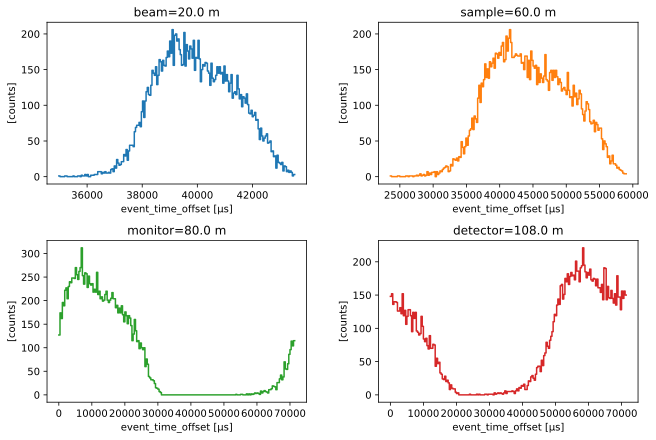

In [3]:
subplots = pp.tiled(2, 2, figsize=(9, 6))
nxevent_data = results.to_nxevent_data()
for i, det in enumerate(detectors):
    data = nxevent_data["detector_number", i]
    subplots[i // 2, i % 2] = (
        data.bins.concat()
        .hist(event_time_offset=200)
        .plot(title=f"{det.name}={det.distance:c}", color=f"C{i}")
    )
subplots

### Computing time-of-flight

We describe in this section the workflow that computes time-of-flight,
given `event_time_zero` and `event_time_offset` for neutron events,
as well as the properties of the source pulse and the choppers in the beamline.

In short, we use a lookup table which can predict the wavelength (or time-of-flight) of the neutrons,
according to their `event_time_offset`.

The workflow can be visualized as follows:

In [4]:
wf = GenericTofWorkflow(run_types=[SampleRun], monitor_types=[])

wf[RawDetector[SampleRun]] = nxevent_data
wf[DetectorLtotal[SampleRun]] = nxevent_data.coords["Ltotal"]
wf[NeXusDetectorName] = "detector"

wf.visualize(TofDetector[SampleRun])

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

By default, the workflow tries to load a `TofLookupTable` from a file.

In this notebook, instead of using such a pre-made file,
we will build our own lookup table from the chopper information and apply it to the workflow.

#### Create the lookup table

The chopper information is used to construct a lookup table that provides an estimate of the real time-of-flight as a function of time-of-arrival.

The [Tof](https://scipp.github.io/tof/) package can be used to propagate a pulse of neutrons through the chopper system to the detectors,
and predict the most likely neutron wavelength for a given time-of-arrival.
More advanced programs such as McStas can of course also be used for even better results.

We typically have hundreds of thousands of pixels in an instrument,
but it is actually not necessary to propagate the neutrons to 10<sup>5</sup> detectors.

Instead, we make a table that spans the entire range of distances of all the pixels,
with a modest resolution,
and use a linear interpolation for values that lie between the points in the table.

To create the table, we thus:

- run a simulation where a pulse of neutrons passes through the choppers and reaches the sample (or any location after the last chopper)
- propagate the neutrons from the sample to a range of distances that span the minimum and maximum pixel distance from the sample (assuming neutron wavelengths do not change)
- bin the neutrons in both distance and time-of-arrival (yielding a 2D binned data array)
- compute the (weighted) mean wavelength inside each bin
- convert the wavelengths to a real time-of-flight to give our final lookup table

This is done using a dedicated workflow:

In [5]:
lut_wf = TofLookupTableWorkflow()
lut_wf[LtotalRange] = detectors[0].distance, detectors[-1].distance
lut_wf[DiskChoppers[AnyRun]] = {
    "chopper": DiskChopper(
        frequency=-chopper.frequency,
        beam_position=sc.scalar(0.0, unit="deg"),
        phase=-chopper.phase,
        axle_position=sc.vector(
            value=[0, 0, chopper.distance.value], unit=chopper.distance.unit
        ),
        slit_begin=chopper.open,
        slit_end=chopper.close,
        slit_height=sc.scalar(10.0, unit="cm"),
        radius=sc.scalar(30.0, unit="cm"),
    )
}
lut_wf[SourcePosition] = sc.vector([0, 0, 0], unit="m")

lut_wf.visualize(TofLookupTable)

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

The table can be computed, and visualized as follows:

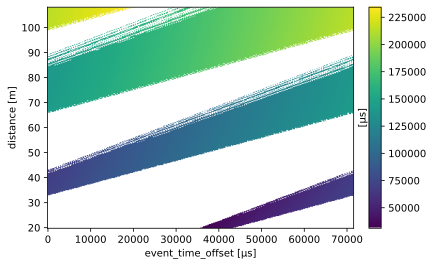

In [6]:
table = lut_wf.compute(TofLookupTable)
table.plot()

#### Computing time-of-flight from the lookup

We now use the above table to perform a bilinear interpolation and compute the time-of-flight of every neutron.
We set the newly computed lookup table as the `TofLookupTable` onto the workflow `wf`.

Looking at the workflow visualization of the `GenericTofWorkflow` above,
we also need to set a value for the `LookupTableRelativeErrorThreshold` parameter.
This puts a cap on wavelength uncertainties: if there are regions in the table where neutrons with different wavelengths are overlapping,
the uncertainty on the predicted wavelength for a given neutron time of arrival will be large.
In some cases, it is desirable to throw away these neutrons by setting a low uncertainty threshold.
Here, we do not have that issue as the chopper in the beamline is ensuring that neutron rays are not overlapping,
and we thus set the threshold to infinity.

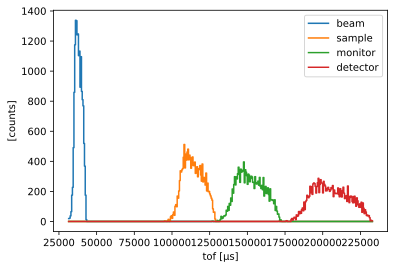

In [7]:
# Set the computed lookup table on the original workflow
wf[TofLookupTable] = table
# Set the uncertainty threshold for the neutrons at the detector to infinity
wf[LookupTableRelativeErrorThreshold] = {"detector": float("inf")}

# Compute neutron tofs
tofs = wf.compute(TofDetector[SampleRun])

tof_hist = tofs.hist(tof=sc.scalar(500.0, unit="us"))
pp.plot({det.name: tof_hist["detector_number", i] for i, det in enumerate(detectors)})

### Converting to wavelength

The time-of-flight of a neutron is commonly used as the fundamental quantity from which one can compute the neutron energy or wavelength.

Here, we compute the wavelengths from the time-of-flight using Scippneutron's `transform_coord` utility,
and compare our computed wavelengths to the true wavelengths which are known for the simulated neutrons.

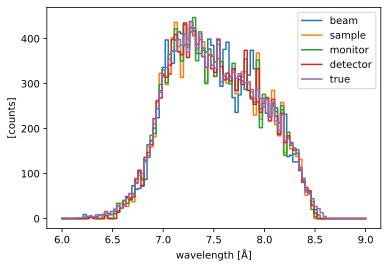

In [8]:
from scippneutron.conversion.graph.beamline import beamline
from scippneutron.conversion.graph.tof import elastic

# Perform coordinate transformation
graph = {**beamline(scatter=False), **elastic("tof")}

# Define wavelength bin edges
bins = sc.linspace("wavelength", 6.0, 9.0, 101, unit="angstrom")

# Compute wavelengths
wav_hist = tofs.transform_coords("wavelength", graph=graph).hist(wavelength=bins)
wavs = {det.name: wav_hist["detector_number", i] for i, det in enumerate(detectors)}

ground_truth = results["detector"].data.flatten(to="event")
ground_truth = ground_truth[~ground_truth.masks["blocked_by_others"]].hist(
    wavelength=bins
)

wavs["true"] = ground_truth
pp.plot(wavs)

We see that all detectors agree on the wavelength spectrum,
which is also in very good agreement with the true neutron wavelengths.

## Pulse-skipping mode

In some beamline configurations, one wishes to study a wide range of wavelengths at a high flux.
This usually means that the spread of arrival times will spill-over into the next pulse if the detector is placed far enough to yield a good wavelength resolution.

To avoid the next pulse polluting the data from the current pulse,
it is common practice to use a pulse-skipping chopper which basically blocks all neutrons every other pulse.
This could also be every 3 or 4 pulses for very long instruments.

The time-distance diagram may look something like:

Plot(ax=<Axes: xlabel='Time [μs]', ylabel='Distance [m]'>, fig=<Figure size 1200x480 with 2 Axes>)

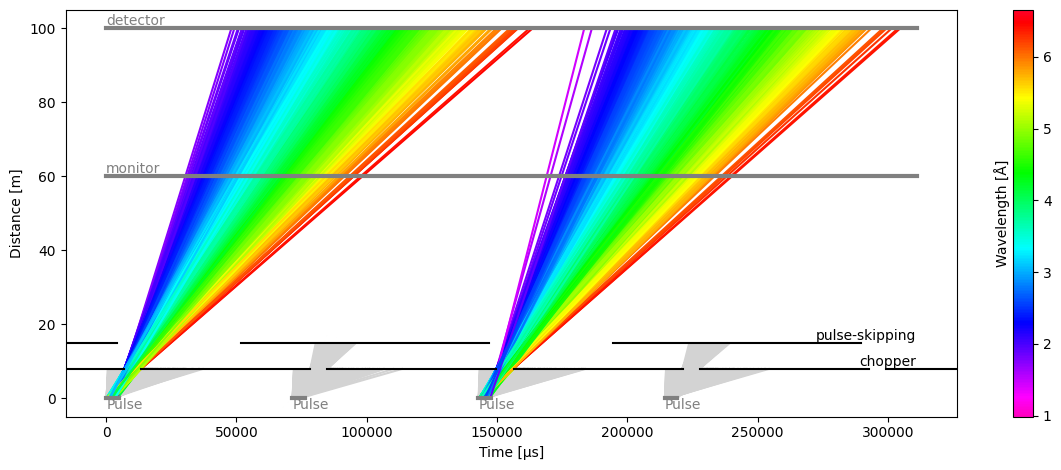

In [9]:
source = tof.Source(facility="ess", pulses=4)
choppers = [
    tof.Chopper(
        frequency=14.0 * Hz,
        open=sc.array(dims=["cutout"], values=[0.0], unit="deg"),
        close=sc.array(dims=["cutout"], values=[33.0], unit="deg"),
        phase=35.0 * deg,
        distance=8.0 * meter,
        name="chopper",
    ),
    tof.Chopper(
        frequency=7.0 * Hz,
        open=sc.array(dims=["cutout"], values=[0.0], unit="deg"),
        close=sc.array(dims=["cutout"], values=[120.0], unit="deg"),
        phase=10.0 * deg,
        distance=15.0 * meter,
        name="pulse-skipping",
    ),
]
detectors = [
    tof.Detector(distance=60.0 * meter, name="monitor"),
    tof.Detector(distance=100.0 * meter, name="detector"),
]

model = tof.Model(source=source, choppers=choppers, detectors=detectors)
results = model.run()
results.plot(blocked_rays=5000)

### Computing time-of-flight

To compute the time-of-flight in pulse skipping mode,
we can use the same workflow as before.

The only difference is that we set the `PulseStride` to 2 to skip every other pulse.

In [10]:
# Lookup table workflow
lut_wf = TofLookupTableWorkflow()
lut_wf[PulseStride] = 2
lut_wf[LtotalRange] = detectors[0].distance, detectors[-1].distance
lut_wf[DiskChoppers[AnyRun]] = {
    ch.name: DiskChopper(
        frequency=-ch.frequency,
        beam_position=sc.scalar(0.0, unit="deg"),
        phase=-ch.phase,
        axle_position=sc.vector(
            value=[0, 0, ch.distance.value], unit=chopper.distance.unit
        ),
        slit_begin=ch.open,
        slit_end=ch.close,
        slit_height=sc.scalar(10.0, unit="cm"),
        radius=sc.scalar(30.0, unit="cm"),
    )
    for ch in choppers
}
lut_wf[SourcePosition] = sc.vector([0, 0, 0], unit="m")
lut_wf[DistanceResolution] = sc.scalar(0.5, unit="m")

The lookup table now spans 2 pulse periods, between 0 and ~142 ms:

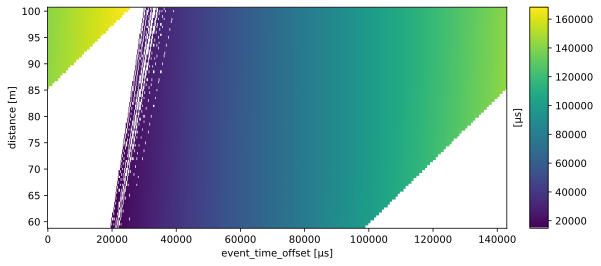

In [11]:
table = lut_wf.compute(TofLookupTable)

table.plot(figsize=(9, 4))

The time-of-flight profiles are then:

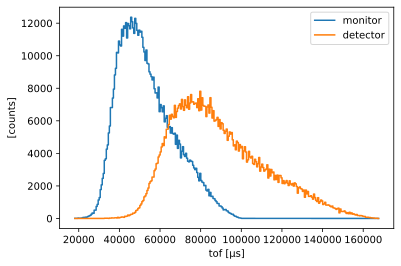

In [12]:
# Reduction workflow
wf = GenericTofWorkflow(run_types=[SampleRun], monitor_types=[])
nxevent_data = results.to_nxevent_data()
wf[RawDetector[SampleRun]] = nxevent_data
wf[DetectorLtotal[SampleRun]] = nxevent_data.coords["Ltotal"]
wf[NeXusDetectorName] = "detector"
wf[TofLookupTable] = table
wf[LookupTableRelativeErrorThreshold] = {"detector": float("inf")}

tofs = wf.compute(TofDetector[SampleRun])

tof_hist = tofs.hist(tof=sc.scalar(500.0, unit="us"))
pp.plot({det.name: tof_hist["detector_number", i] for i, det in enumerate(detectors)})

### Conversion to wavelength

We now use the `transform_coords` as above to convert to wavelength.

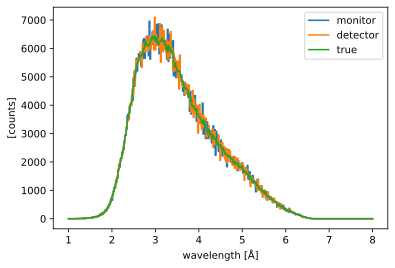

In [13]:
# Define wavelength bin edges
bins = sc.linspace("wavelength", 1.0, 8.0, 401, unit="angstrom")

# Compute wavelengths
wav_hist = tofs.transform_coords("wavelength", graph=graph).hist(wavelength=bins)
wavs = {det.name: wav_hist["detector_number", i] for i, det in enumerate(detectors)}

ground_truth = results["detector"].data.flatten(to="event")
ground_truth = ground_truth[~ground_truth.masks["blocked_by_others"]].hist(
    wavelength=bins
)

wavs["true"] = ground_truth
pp.plot(wavs)